In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
from warnings import simplefilter
import logging

%matplotlib inline
warnings.filterwarnings('ignore')
simplefilter("ignore", category=ConvergenceWarning)
logging.basicConfig(level=logging.INFO)
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression,ElasticNet,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
import xgboost as xgb




### Descarga Datos desde Kaggle

In [6]:
#https://www.kaggle.com/datasets/luisfelipetn/valor-casas-usadas-chile-rm-08032023
#!kaggle datasets download -d luisfelipetn/valor-casas-usadas-chile-rm-08032023
#!unzip valor-casas-usadas-chile-rm-08032023.zip

In [7]:
'''-Price_CLP: Precio de casa en pesos chilenos (CLP)
-Price_UF: Precio de casa en unidades de fomento (UF)
-Price_USD: Precio de casa en dolares americanos (USD)
-Comuna: Comuna en la que se encuentra la casa.
-Ubicacion: Ubicación más específica de la casa
-Dorms: Cuantas habitaciones tiene la casa
-Baths: Cuantos baños tiene la casa
-Built Area: Cuantos metros cuadrados construidos tiene la casa
-Total Area: Cuantos metros cuadrados tiene toda la propiedad
-Parking: Cuantos estacionamentos tiene la casa
-id: Codigo de la casa en https://chilepropiedades.cl/ ; Ej: https://chilepropiedades.cl/ver-publicacion/11607213
-Realtor: El corredor de bienes raíces'''

'-Price_CLP: Precio de casa en pesos chilenos (CLP)\n-Price_UF: Precio de casa en unidades de fomento (UF)\n-Price_USD: Precio de casa en dolares americanos (USD)\n-Comuna: Comuna en la que se encuentra la casa.\n-Ubicacion: Ubicación más específica de la casa\n-Dorms: Cuantas habitaciones tiene la casa\n-Baths: Cuantos baños tiene la casa\n-Built Area: Cuantos metros cuadrados construidos tiene la casa\n-Total Area: Cuantos metros cuadrados tiene toda la propiedad\n-Parking: Cuantos estacionamentos tiene la casa\n-id: Codigo de la casa en https://chilepropiedades.cl/ ; Ej: https://chilepropiedades.cl/ver-publicacion/11607213\n-Realtor: El corredor de bienes raíces'

### Carga CSV

In [8]:
df_casas=pd.read_csv('2023-07-18 Propiedades Web Scrape.csv')

In [159]:
df_casas_sc=df_casas.drop(columns=['Comuna'],axis=1)
df_casas_sc.dropna(how='any',inplace=True)
df_casas_sc=df_casas_sc[(df_casas_sc['Total Area']<250000) & (df_casas_sc['Built Area']<300000)]

### Selección de Variables

In [143]:
df_casas=pd.get_dummies(df_casas,columns=['Comuna'],drop_first=True)

In [144]:
df_casas=df_casas.drop(columns=['Ubicacion','id','Realtor','Price_CLP','Price_USD'],axis=1)

### EDA

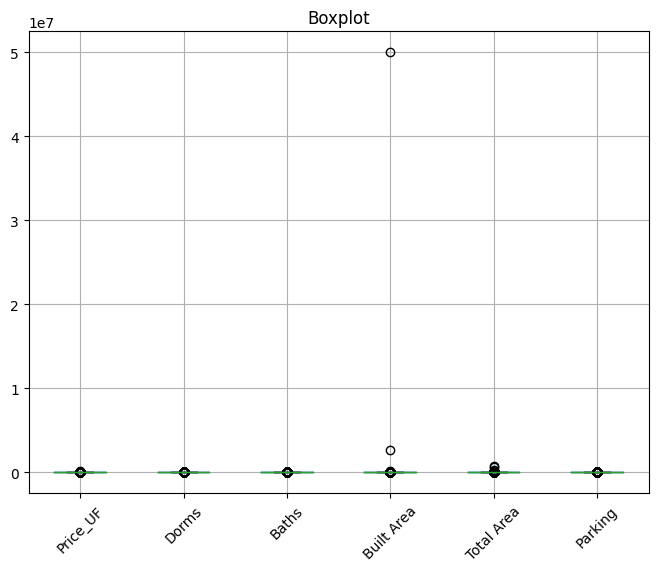

In [135]:
# Análisis de Outliers
df_casas.iloc[:,:6].boxplot(figsize=(8, 6))
plt.title('Boxplot')
plt.xticks(rotation=45)
plt.show()

In [145]:
#Se eliminan NaNs y Outliers
df_casas.dropna(how='any',inplace=True)
df_casas=df_casas[(df_casas['Total Area']<250000) & (df_casas['Built Area']<300000)]

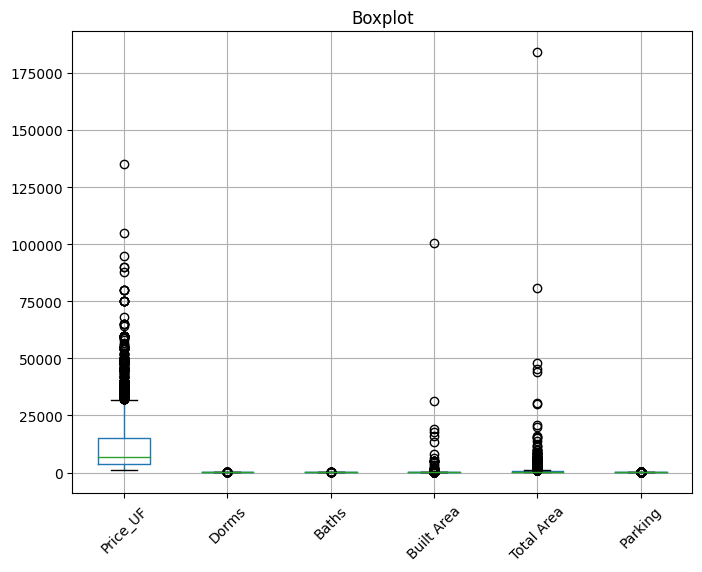

In [137]:
df_casas.iloc[:,:6].boxplot(figsize=(8, 6))
plt.title('Boxplot')
plt.xticks(rotation=45)
plt.show()

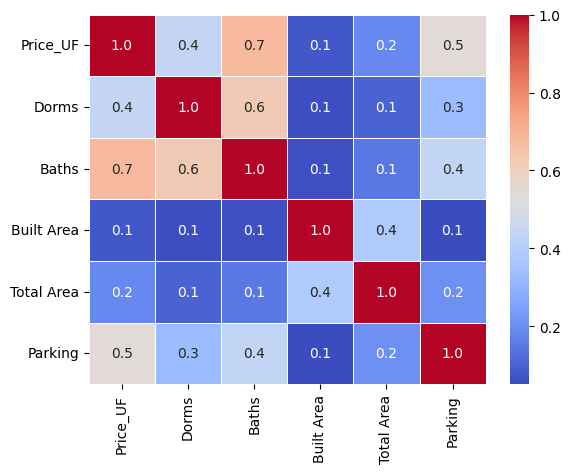

In [27]:
sns.heatmap(df_casas.iloc[:,:6].corr(),annot=True,fmt=".1f",cmap='coolwarm',linewidths=0.5)
plt.show()

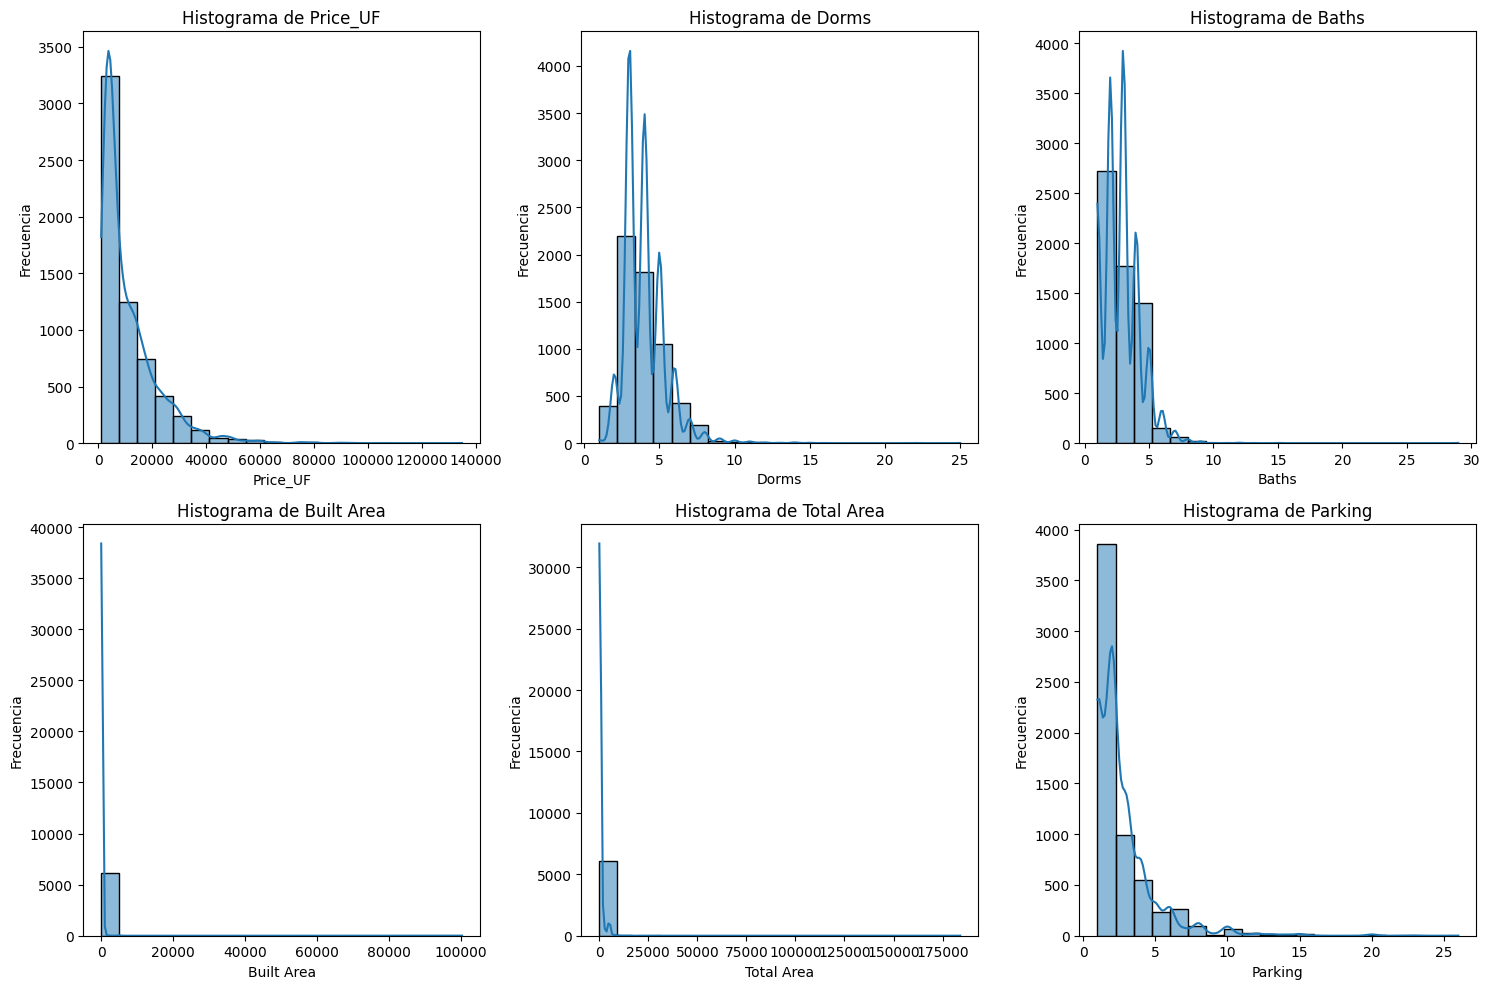

In [30]:
ncols=3
nrows=2
subset=df_casas.iloc[:,:6]
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows),tight_layout=True)

axes = axes.flatten()  

for i, column in enumerate(subset.columns):
    sns.histplot(subset[column], ax=axes[i], kde=True,bins=20,palette='tab10')
    axes[i].set_title(f'Histograma de {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frecuencia')


In [76]:
#Transformación logarítmica de la variable objetivo
df_casas['Price_UF'] = np.log(df_casas['Price_UF'])

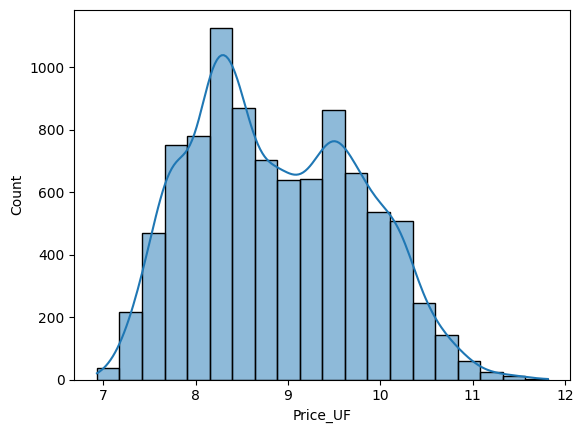

In [77]:
sns.histplot(df_casas['Price_UF'], kde=True,bins=20,palette='tab10')
plt.show()

### Modelo de Regresion

In [32]:
def modelos_regresion (X,y):
    #Se particionan los datos en entrenamiento y testeo
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)
    
    #Se escalan los datos aplicando StandardScaler
    sc=StandardScaler()
    X_train_sc=sc.fit_transform(X_train)
    X_test_sc=sc.transform(X_test)
    
    #Se definen los siguientes modelos de regresión con los respectivos hiperparámetros
    models = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {
            'fit_intercept': [True, False]
                            }
    },
    'ElasticNet': {
        'model': ElasticNet(),
        'params': {
            'alpha': [0.1, 1, 10],
            'l1_ratio': [0.1, 0.5, 0.9],
            'fit_intercept': [True, False]
        }
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1, 10],
            'fit_intercept': [True, False]
        }
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.1, 1, 10],
            'fit_intercept': [True, False]
        }
    },
    'DecisionTree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'criterion': ['mse', 'friedman_mse', 'mae'],
            'splitter': ['best', 'random']
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [10, 50, 100],
            'criterion': ['squared_error', 'absolute_error','friedman_mse']
        }
    },

    'KNeighborsRegressor':{
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors':[3,5,6,10],
            'weights':['uniform','distance'],
            'metric':['cosine','euclidean','manhattan']
        }

    },
    'GradientBoostingRegressor':{
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': [10, 50, 100],
            'criterion': ['squared_error', 'friedman_mse']
        }

    },
    'XGBoostRegressor':{
        'model': xgb.XGBRegressor(objective='reg:squarederror'),
        'params': {'n_estimators': [100, 200],
                   'learning_rate': [0.05, 0.1],
                   'max_depth': [3, 5],
                   'subsample': [0.7, 0.8],
                   'colsample_bytree': [0.8],
                   'min_child_weight': [1, 3],
                   'reg_alpha': [0, 0.1],
                   'reg_lambda': [0.1, 0.5]
        }
    }
    
}
    # Se definen las siguientes métricas de evaluación
    scoring = {
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error',
    'R2': 'r2'}

    results=[]

    #Se realiza un GridSearchCV para cada modelo probando con diferentes hiperparámetros y validando con 5 folds
    for model_name, model in models.items():

        grid = GridSearchCV(model['model'], model['params'], cv=5, scoring=scoring,n_jobs=-1,refit='R2')
        grid.fit(X_train_sc, y_train)
        logging.info(f'Modelo {model_name} terminado')

        #Se guardan los resultados en un DataFrame
        results.append({
            'Modelo': model_name,
            'Best_Estimator': grid.best_estimator_,
            'Best_Params': grid.best_params_,
            'Best_R2_Score': grid.best_score_,
            'Best_MAE': -grid.cv_results_['mean_test_MAE'][grid.best_index_],  
            'Best_MSE': -grid.cv_results_['mean_test_MSE'][grid.best_index_] })

    results_df=pd.DataFrame(results)
    
    return results_df


### Aplicación Modelo de regresion sin Comunas

In [33]:
df_casas_1=df_casas.dropna(how='any')
df_casas_1=df_casas_1[(df_casas_1['Total Area']<250000) & (df_casas_1['Built Area']<300000)]

X_sin_comunas=df_casas_1[['Dorms','Baths','Built Area','Total Area','Parking']]
y_sin_comunas=np.log(df_casas_1['Price_UF'])

df_sin_comunas=modelos_regresion(X_sin_comunas,y_sin_comunas)

INFO:root:Modelo LinearRegression terminado
INFO:root:Modelo ElasticNet terminado
INFO:root:Modelo Ridge terminado
INFO:root:Modelo Lasso terminado
INFO:root:Modelo DecisionTree terminado
INFO:root:Modelo RandomForest terminado
INFO:root:Modelo KNeighborsRegressor terminado
INFO:root:Modelo GradientBoostingRegressor terminado
INFO:root:Modelo XGBoostRegressor terminado


### Aplicación Modelo de regresion con Comunas

In [38]:
df_casas_2=pd.get_dummies(df_casas,columns=['Comuna'],drop_first=True)
df_casas_2=df_casas_2.drop(columns=['Ubicacion','id','Realtor','Price_CLP','Price_USD'],axis=1)
df_casas_2=df_casas_2.dropna(how='any')
df_casas_2=df_casas_2[(df_casas_2['Total Area']<250000) & (df_casas_2['Built Area']<300000)]

X_con_comunas=df_casas_2.drop(columns=['Price_UF'],axis=1)
y_con_comunas=np.log(df_casas_2['Price_UF'])

df_con_comunas=modelos_regresion(X_con_comunas,y_con_comunas)

INFO:root:Modelo LinearRegression terminado
INFO:root:Modelo ElasticNet terminado
INFO:root:Modelo Ridge terminado
INFO:root:Modelo Lasso terminado
INFO:root:Modelo DecisionTree terminado
INFO:root:Modelo RandomForest terminado
INFO:root:Modelo KNeighborsRegressor terminado
INFO:root:Modelo GradientBoostingRegressor terminado
INFO:root:Modelo XGBoostRegressor terminado


In [64]:
# Se agrega función que cálcula el R2 Ajustado para ambos modelos

def R2_ajustado(df,X):
    list=[]
    for i in df['Best_R2_Score'].values:
        list.append((1-((X.shape[0]-1)/(X.shape[0]-X.shape[1]-1))*(1-i)))
    return list
    

In [67]:
df_con_comunas['R2 Ajustado']=R2_ajustado(df_con_comunas,X_con_comunas)
df_sin_comunas['R2 Ajustado']=R2_ajustado(df_sin_comunas,X_sin_comunas)

In [68]:
df_con_comunas

,Modelo,Best_Estimator,Best_Params,Best_R2_Score,Best_MAE,Best_MSE,R2 Ajustado
0,LinearRegression,LinearRegression(),{'fit_intercept': True},0.785507,0.290005,0.167169,0.783532
1,ElasticNet,"ElasticNet(alpha=0.1, l1_ratio=0.1)","{'alpha': 0.1, 'fit_intercept': True, 'l1_rati...",0.792964,0.300927,0.161310,0.791058
2,Ridge,Ridge(alpha=10),"{'alpha': 10, 'fit_intercept': True}",0.786031,0.290084,0.166760,0.784061
3,Lasso,Lasso(alpha=0.1),"{'alpha': 0.1, 'fit_intercept': True}",0.647978,0.424873,0.274257,0.644738
4,DecisionTree,DecisionTreeRegressor(criterion='friedman_mse'...,"{'criterion': 'friedman_mse', 'splitter': 'ran...",0.834460,0.252982,0.129020,0.832936
5,RandomForest,(DecisionTreeRegressor(criterion='absolute_err...,"{'criterion': 'absolute_error', 'n_estimators'...",0.896845,0.200318,0.080379,0.895895
6,KNeighborsRegressor,"KNeighborsRegressor(metric='manhattan', n_neig...","{'metric': 'manhattan', 'n_neighbors': 6, 'wei...",0.850013,0.241770,0.116833,0.848632
7,GradientBoostingRegressor,"([DecisionTreeRegressor(max_depth=3,\n ...","{'criterion': 'squared_error', 'n_estimators':...",0.897920,0.208269,0.079525,0.896980
8,XGBoostRegressor,"XGBRegressor(base_score=None, booster=None, ca...","{'colsample_bytree': 0.8, 'learning_rate': 0.1...",0.916125,0.188059,0.065353,0.915353


In [69]:
df_sin_comunas

,Modelo,Best_Estimator,Best_Params,Best_R2_Score,Best_MAE,Best_MSE,R2 Ajustado
0,LinearRegression,LinearRegression(),{'fit_intercept': True},0.559508,0.465878,0.353265,0.559107
1,ElasticNet,ElasticNet(alpha=0.1),"{'alpha': 0.1, 'fit_intercept': True, 'l1_rati...",0.561952,0.481097,0.351404,0.561553
2,Ridge,Ridge(alpha=10),"{'alpha': 10, 'fit_intercept': True}",0.559578,0.466104,0.353207,0.559177
3,Lasso,Lasso(alpha=0.1),"{'alpha': 0.1, 'fit_intercept': True}",0.551090,0.490397,0.360124,0.550681
4,DecisionTree,DecisionTreeRegressor(criterion='friedman_mse'),"{'criterion': 'friedman_mse', 'splitter': 'best'}",0.685264,0.354620,0.252319,0.684977
5,RandomForest,(DecisionTreeRegressor(criterion='absolute_err...,"{'criterion': 'absolute_error', 'n_estimators'...",0.821155,0.275660,0.143233,0.820993
6,KNeighborsRegressor,"KNeighborsRegressor(metric='manhattan', n_neig...","{'metric': 'manhattan', 'n_neighbors': 10, 'we...",0.789754,0.295875,0.168298,0.789563
7,GradientBoostingRegressor,([DecisionTreeRegressor(criterion='friedman_ms...,"{'criterion': 'friedman_mse', 'n_estimators': ...",0.828752,0.273850,0.137199,0.828596
8,XGBoostRegressor,"XGBRegressor(base_score=None, booster=None, ca...","{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.833499,0.270762,0.133383,0.833348


In [76]:
print(f"Mejor modelo dataset con comunas: {df_con_comunas.loc[df_con_comunas['R2 Ajustado'].idxmax()]['Modelo']}")
print(f"Mejor hiperparámetros modelo con comunas: {df_con_comunas.loc[df_con_comunas['R2 Ajustado'].idxmax()]['Best_Params']}")
print("=====================================================================================================")
print(f"Mejor modelo dataset sin comunas: {df_sin_comunas.loc[df_sin_comunas['R2 Ajustado'].idxmax()]['Modelo']}")
print(f"Mejor hiperparámetros modelo sin comunas: {df_sin_comunas.loc[df_sin_comunas['R2 Ajustado'].idxmax()]['Best_Params']}")

Mejor modelo dataset con comunas: XGBoostRegressor
Mejor hiperparámetros modelo con comunas: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.7}
Mejor modelo dataset sin comunas: XGBoostRegressor
Mejor hiperparámetros modelo sin comunas: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.5, 'subsample': 0.8}


### Clusterización de Variables usando K-Means

In [39]:
#leer los datos
df_casas=pd.read_csv('2023-07-18 Propiedades Web Scrape.csv')

#preprocesamiento
def preprocesamiento(df_original:pd.DataFrame)->pd.DataFrame:
    #Se eliminan NaNs y Outliers y se transforma la variable objetivo
    df_original.dropna(how='any',inplace=True)
    df_original=df_original[(df_original['Total Area']<250000) & (df_original['Built Area']<100000)]
    df_original=df_original.drop(columns=['Ubicacion','id','Realtor','Price_CLP','Price_USD'],axis=1)
    df_original['Price_UF'] = df_original['Price_UF'].apply(lambda x : np.log(x))
    
    #dummies de comunas

    return df_original

df_casas_preproc = preprocesamiento(df_casas)

# Vamos a hacer una clusteririzacion de los datos y observar si se pueden identificar grupos de propiedades y tambien si estos grupos se relacionan
# con las comunas de santiago
# Para ello vamos a utilizar KMeans para realizar una clusterizacion de los datos

X_cluster = df_casas_preproc.drop(columns=['Comuna'])
y = df_casas_preproc['Comuna']

sc=StandardScaler()
X_cluster_sc=sc.fit_transform(X_cluster)
df_cluster=pd.DataFrame(X_cluster_sc,columns=X_cluster.columns)

# No vamos a realizar una reducción de dimensionalidad ya que tenemos pocas columnas

#almacenamos la inercia para construir la grafica del codo, para la eleccion de clusters

inertia=[]
for i in range(1,16):
    kmeans = KMeans(n_clusters=i,random_state=4431,max_iter=1000).fit(X_cluster_sc)
    inertia.append(kmeans.inertia_)

plt.plot(range(1,16),inertia,marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [57]:
#re-entrenamos con los 7 clusters, cuando ya se estabiliza la inercia
kmeans = KMeans(n_clusters=7,random_state=4431,max_iter=1000).fit(X_cluster_sc)

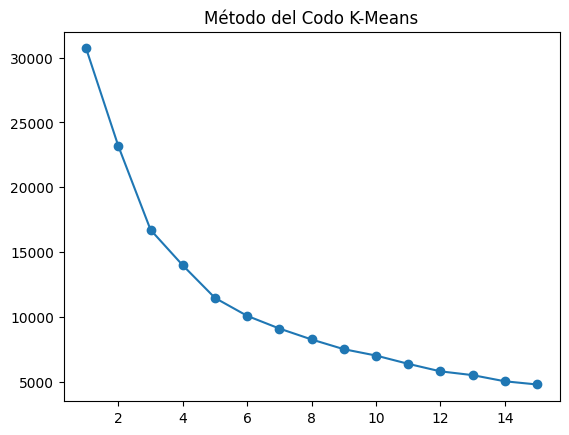

In [58]:
# extraemos labels de clusters y centroides
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [59]:
# dibujamos grafico de dispersion entre precio y dorms y usando como hue los clusters y tambien dibujando sus centroides.
sns.scatterplot(x=df_cluster.iloc[:,0],y=df_cluster.iloc[:,1] ,hue=labels, s=50,palette='tab10')
sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1], color='red', s=200, alpha=0.75, marker='*')
plt.show()


In [ ]:
# mapear al dataset original los clusters

df_cluster['Cluster']=labels
df_cluster['Comuna']=y.to_numpy()

In [ ]:
#observar clusters y precios medios y cuenta de casas.
df_cluster.groupby('Cluster').agg({'Price_UF':['mean','std','count']})

In [ ]:
# Observemos la distribucion de precios mediante un boxplot para cada cluster
sns.boxplot(x='Cluster',y='Price_UF',data=df_cluster)
plt.show()

In [ ]:
# generemos un dataframe agrupado por cluster y comuna para analizar la preponderancia de algunas comunas a los respectivos clusters
df_cluster_comuna=pd.DataFrame(df_cluster.groupby(by=['Cluster','Comuna']).agg({'Price_UF':['count']}).reset_index().values,columns=['cluster','comuna','cuenta'])

In [ ]:
# ordenamos para poder extraer las top comunas de cada cluster
df_cluster_comuna=df_cluster_comuna.sort_values(by=['cluster','cuenta'],ascending=False)

In [ ]:
# graficamos en una grilla las top comunas de cada cluster y la cantidad de veces que aparecen
ncols=3
nrows=3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows),tight_layout=True)

axes = axes.flatten()  

for i,cluster_i in enumerate(df_cluster_comuna.cluster.unique()):
    df_cluster_comuna_i=df_cluster_comuna.query(f'cluster == {cluster_i}').head(5)
    sns.barplot(df_cluster_comuna_i, ax=axes[i],x='comuna',y='cuenta')
    axes[i].set_title(f'Cluster {cluster_i}')